In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', message='.*No further splits with positive gain.*')

In [2]:
from os import path

PROJECT_ROOT = path.abspath(path.join(globals()['_dh'][0], '..'))
DATALAKE_PATH = path.abspath(path.join(PROJECT_ROOT, '..', '..', 'datalake', 'xplainproj'))
FQFN_PROCESSED_DF = path.join(DATALAKE_PATH, 'processed', f'processed_20250207.jsonl')
MODEL_DIR = path.abspath(path.join(PROJECT_ROOT, 'xplainproj', 'classifier'))

In [3]:
from os import path

from xplainproj.classifier.onnx_exporter import WEIGHTS_FILE_NAME
from xplainproj.classifier.xplain_configuration import ModelConf
from xplainproj.classifier.xplain_classifier import XplainClassifier

model_conf = ModelConf()

print(f'Model Class: {XplainClassifier.__name__}')
fqfn_model_save = path.join(MODEL_DIR, WEIGHTS_FILE_NAME)
trained_model = XplainClassifier(model_conf=model_conf)
trained_model.load_model_weights(fqfn_model_save)

Model Class: XplainClassifier


In [4]:
import pandas as pd

df = pd.read_json(f'file://{FQFN_PROCESSED_DF}', orient='records', lines=True)
print(f'df shape={df.shape}')
print(f'df columns={df.columns}')

df shape=(699, 11)
df columns=Index(['file_name', 'fqfn', 'text_body', 'label', 'longest_code_line_length',
       'median_code_line_length', 'lines_of_code', 'code_size_in_bytes',
       'ratio_of_comments_to_code', 'is_64base_content_present',
       'file_name_embedding'],
      dtype='object')


## Shapley Permutation Explainer


In [5]:
import sys

if (module_name := 'trainer.shapley_permutation_explainer') in sys.modules:
    del sys.modules[module_name]

In [6]:
from utils.pt_utils import NumpyDataset
from trainer.shapley_permutation_explainer import compute_shap_values_for_high_dim
from trainer.xplain_dataset_pt import XplainPtDataset

# Compute SHAP values
dataset = XplainPtDataset(df)
feature_names: list[str] = dataset.feature_names

shap_values = compute_shap_values_for_high_dim(trained_model, dataset, input_features=ModelConf.input_features)

In [7]:
print(f'feature_names={feature_names}')
print(f'type = {type(shap_values)}')
print(f'shape = {shap_values.shape}')
# print(f'data = {shap_values.data}')

feature_names=['longest_code_line_length', 'median_code_line_length', 'lines_of_code', 'code_size_in_bytes', 'ratio_of_comments_to_code', 'is_64base_content_present', 'file_name_embedding']
type = <class 'shap._explanation.Explanation'>
shape = (100, 7)


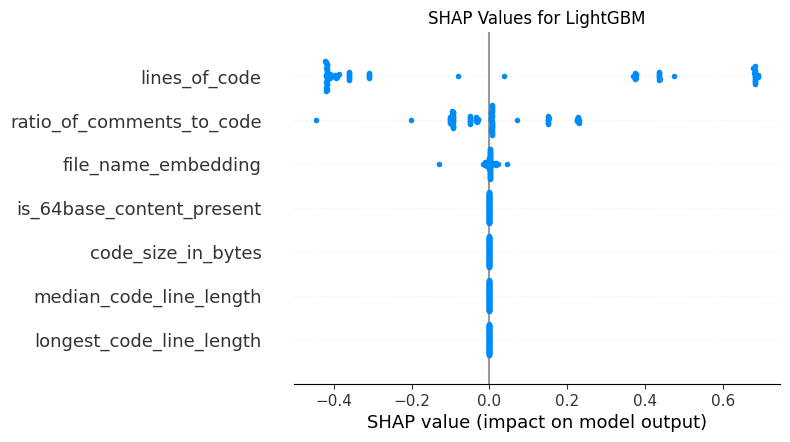

In [8]:
import matplotlib.pyplot as plt
import shap

shap_values_class = shap_values.values

# Plot SHAP values for the class {category}
shap.summary_plot(shap_values_class, feature_names=feature_names, show=False)
plt.title(f'SHAP Values for LightGBM')
plt.show()

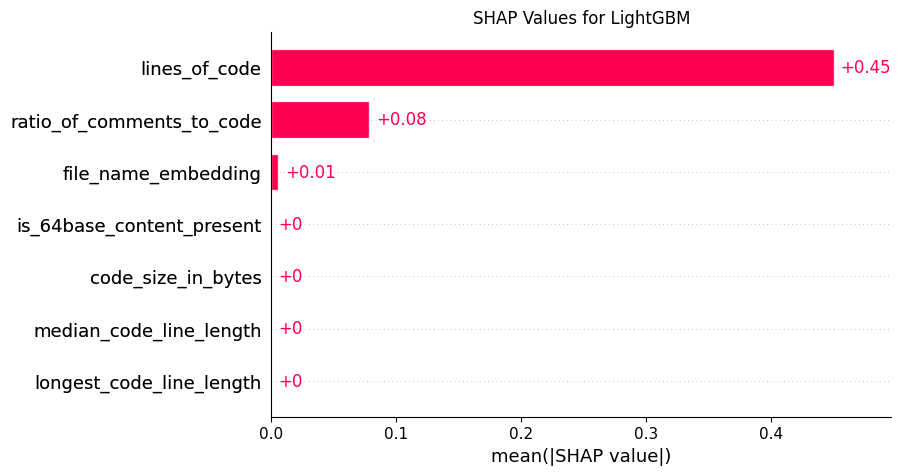

In [9]:
import matplotlib.pyplot as plt
import shap

# Extract SHAP values
shap_values_class = shap_values.values

# Create a new Explanation object
shap_values_class_explanation = shap.Explanation(
    values=shap_values_class,
    data=shap_values.data,
    feature_names=feature_names
)

# Plot SHAP values for the class {category}
shap.plots.bar(shap_values_class_explanation, show=False)

plt.title(f'SHAP Values for LightGBM')
plt.show()

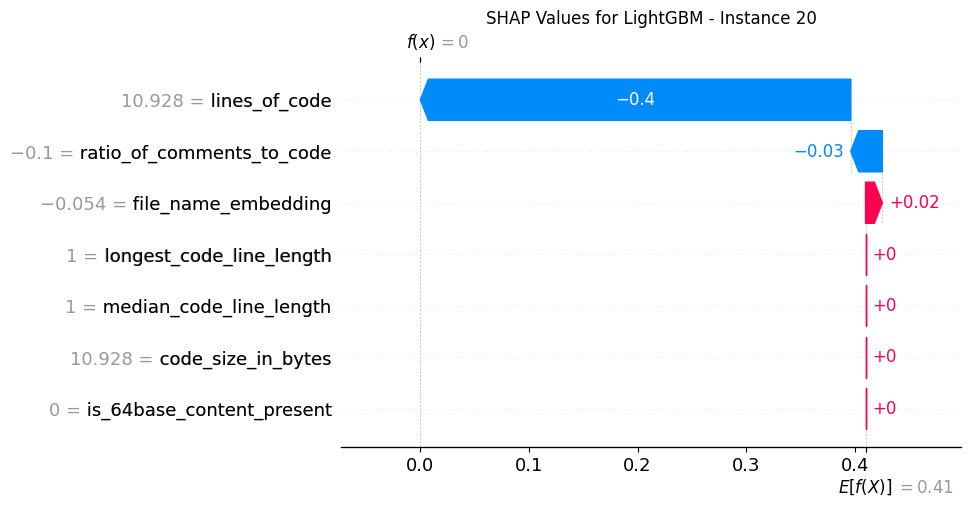

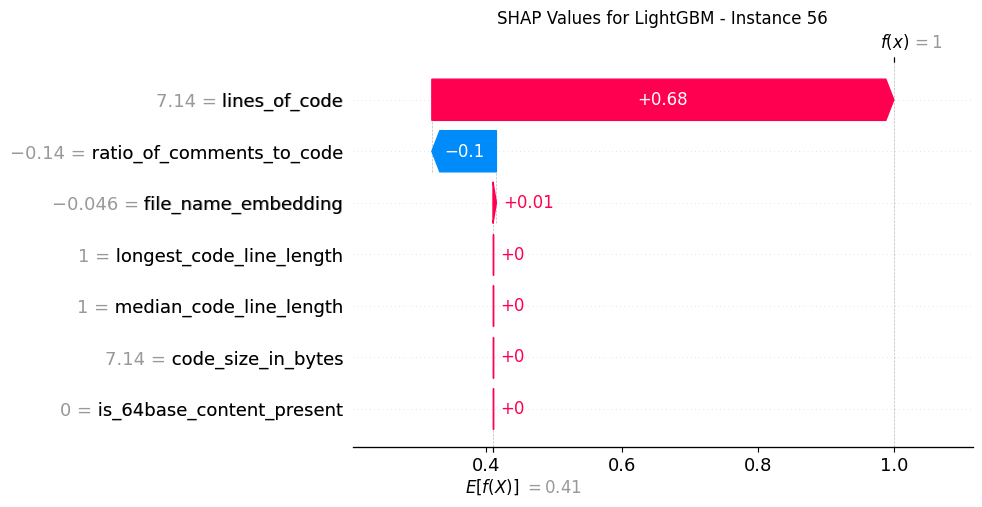

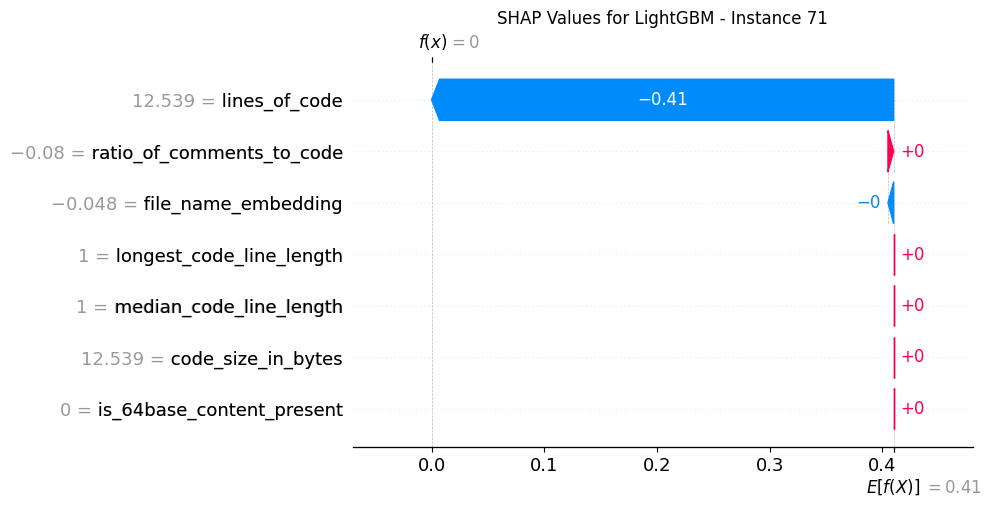

In [10]:
import random
import matplotlib.pyplot as plt
import shap

for instance_index in random.sample(range(shap_values.shape[0]), k=3):
    # instance_index is an identificator for a row in shap_values result set

    # Extract SHAP values for the specified class and instance
    shap_values_instance_class = shap_values.values[instance_index, :]

    # Create a new Explanation object for this specific instance and class
    shap_values_instance_class_explanation = shap.Explanation(
        values=shap_values_instance_class,
        base_values=shap_values.base_values[instance_index, ],
        data=shap_values.data[instance_index],
        feature_names=feature_names
    )

    # Plot SHAP values for the specific instance and class
    shap.plots.waterfall(shap_values_instance_class_explanation, show=False)

    plt.title(f'SHAP Values for LightGBM - Instance {instance_index}')
    plt.show()


## Kernel Shapley Explainer

In [11]:
import logging
for log_name in ['shap', 'matplotlib', 'sklearn']:
    logging.getLogger(log_name).setLevel(logging.WARNING)

Outlier Class: XplainClassifier
Shapley values computation for X.shape=(100, 38);


  0%|          | 0/14 [00:00<?, ?it/s]/Users/shershen/virtualenvs/tensor_craft/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shershen/virtualenvs/tensor_craft/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/14 [00:00<?, ?it/s]/Users/shershen/virtualenvs/tensor_craft/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/14 [00:00<?, ?it/s]/Users/shershen/virtualenvs/tensor_craft/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  w

Global SHAP vizualization for X.shape=(100, 38); shap_values.shape=(100, 7); len(feature_names)=7


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


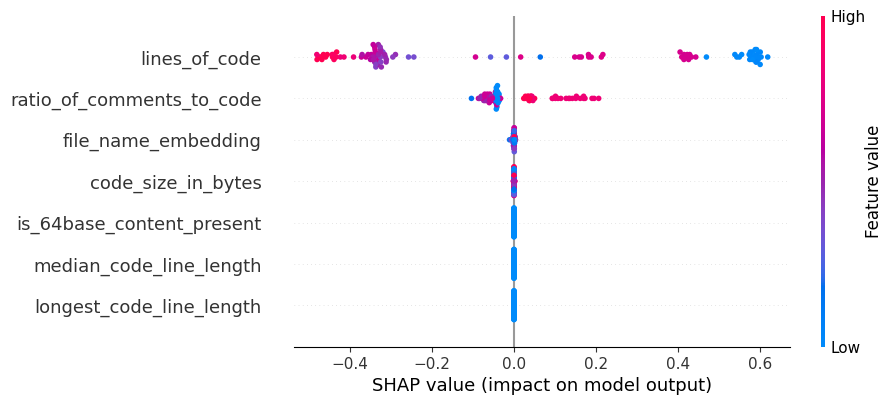

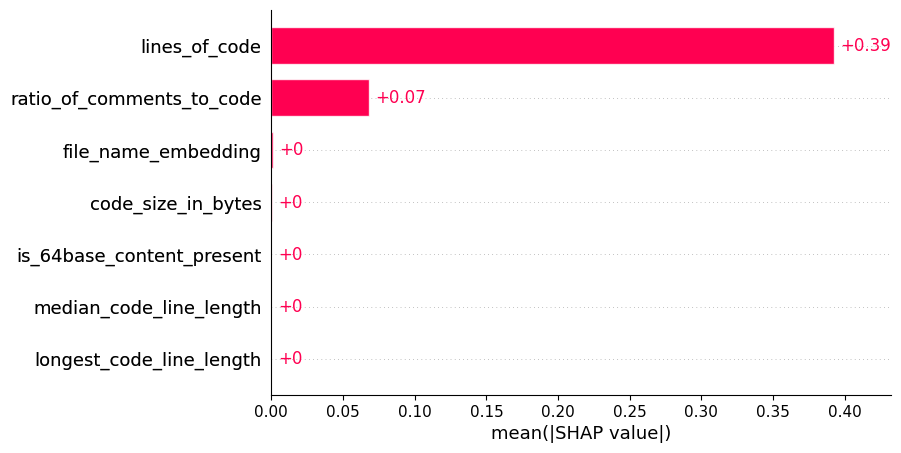

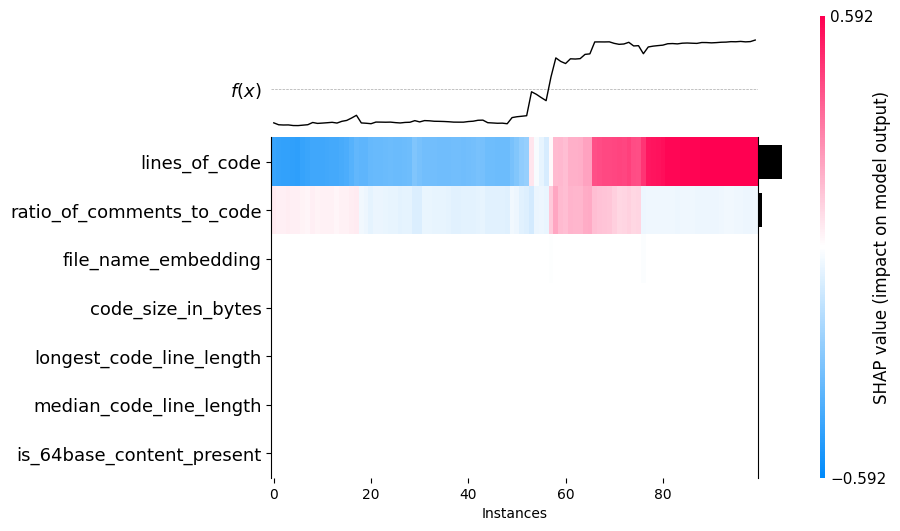

Local index=2 vizualization for X.shape=(100, 38); shap_values.shape=(100, 7); len(feature_names)=7


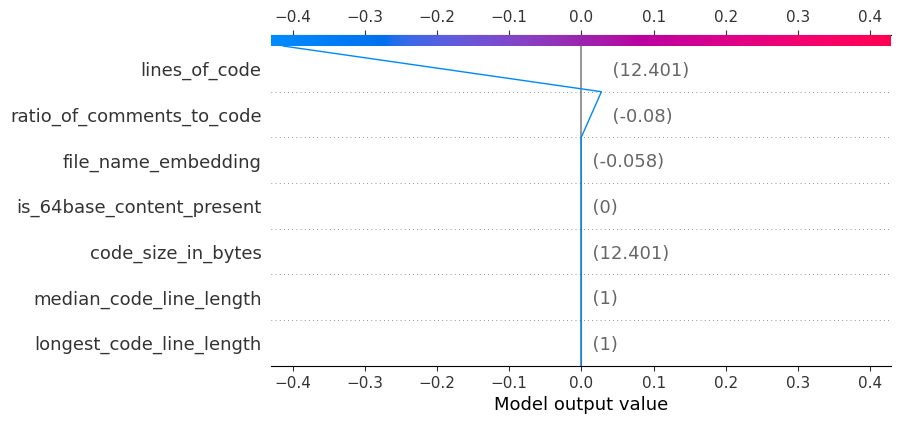

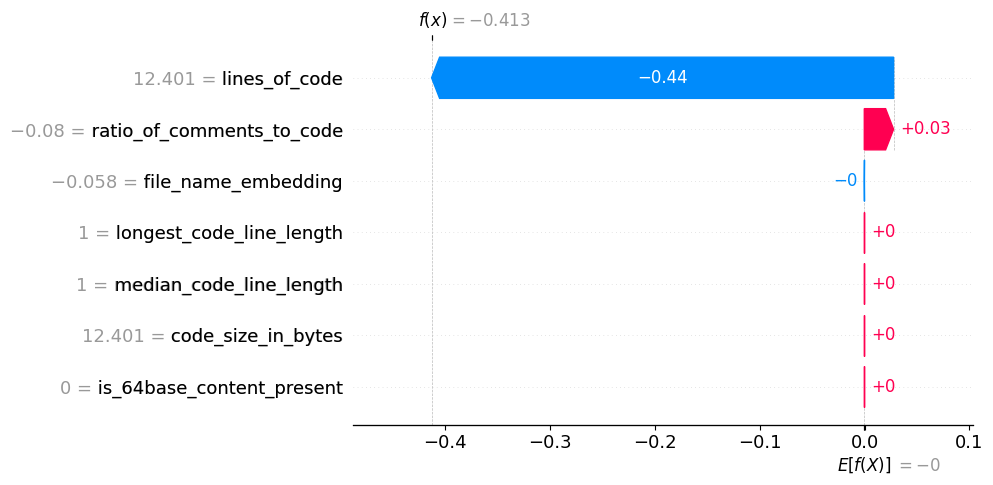

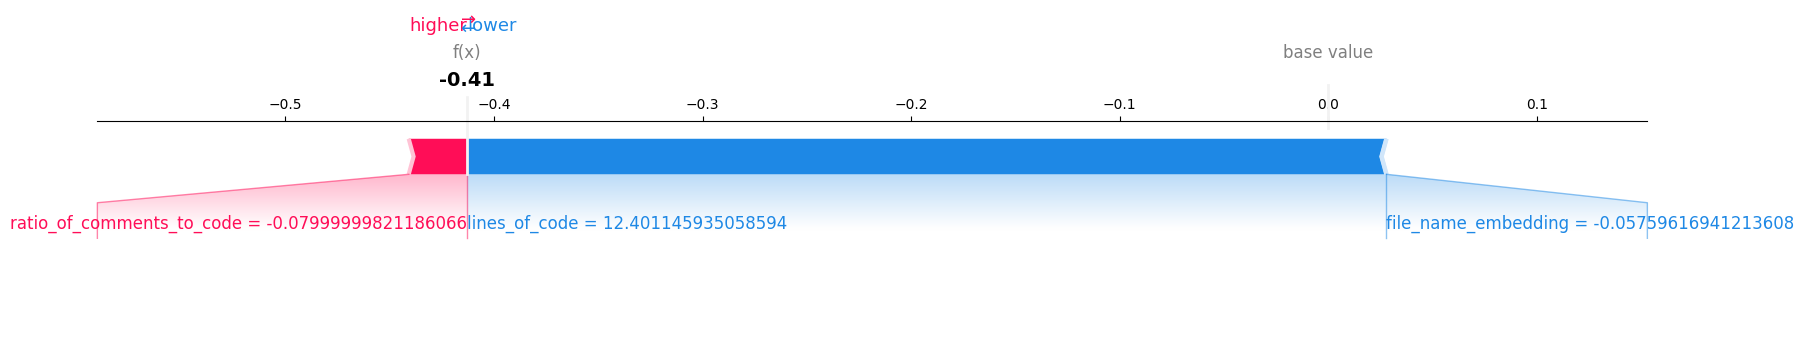

In [12]:
import numpy as np
from os import path
from sklearn.model_selection import train_test_split

from trainer.txt_dataset import concat_row_elements
from xplainproj.classifier.onnx_exporter import WEIGHTS_FILE_NAME
from xplainproj.classifier.xplain_configuration import ModelConf, TrainerConf
from xplainproj.classifier.xplain_classifier import XplainClassifier

from trainer.shapley_kernel_explainer import (
    compute_kernel_shapley_values_for_high_dim, shap_bar_plot, shap_beeswarm_plot, shap_heatmap_plot, shap_decision_plot, shap_force_plot, shap_waterfall_plot
)


for outlier_class in [XplainClassifier]:
    print(f'Outlier Class: {outlier_class.__name__}')
    feature_names=[name for name, _, _ in ModelConf.input_features]

    train_df, test_df = train_test_split(
        df,
        test_size=TrainerConf.dataset_split_ratio,
        random_state=TrainerConf.dataset_random_state
    )

    X: np.ndarray = np.stack(test_df[feature_names].apply(concat_row_elements, axis=1).to_list())

    # Sample 1000 rows (vectors) without replacement
    background_size: int = 50
    sampled_indexes = np.random.choice(X.shape[0], size=background_size * 2, replace=False)
    X = X[sampled_indexes]

    fqfn_model_weights = path.join(MODEL_DIR, WEIGHTS_FILE_NAME)
    trained_model = outlier_class(model_conf=ModelConf())
    trained_model.load_model_weights(fqfn_model_weights)

    print(f'Shapley values computation for {X.shape=};')
    shap_values = compute_kernel_shapley_values_for_high_dim(
        model=trained_model,  # model with *decision_function* method
        X=X,
        input_features=ModelConf.input_features,
        num_parallel_calls=7
    )

    print(f'Global SHAP vizualization for {X.shape=}; {shap_values.shape=}; {len(feature_names)=}')
    shap_beeswarm_plot(shap_values=shap_values, input_features=ModelConf.input_features, X=X)
    shap_bar_plot(shap_values=shap_values, input_features=ModelConf.input_features, X=X)
    shap_heatmap_plot(shap_values=shap_values, input_features=ModelConf.input_features, X=X)

    index = 2
    print(f'Local {index=} vizualization for {X.shape=}; {shap_values.shape=}; {len(feature_names)=}')
    base_value = shap_values.mean(axis=0).sum()  # Use the global mean as an approximation
    shap_decision_plot(shap_values=shap_values, base_value=base_value, input_features=ModelConf.input_features, X=X, index=index)
    shap_waterfall_plot(shap_values=shap_values, base_value=base_value, input_features=ModelConf.input_features, X=X, index=index)
    shap_force_plot(shap_values=shap_values, base_values=base_value, input_features=ModelConf.input_features, X=X, index=index)
